In [22]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import functools
from google.colab import drive

In [23]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
content_path = '/content/drive/MyDrive/Colab Notebooks/Images/Gates.jpg'
style_path = '/content/drive/MyDrive/Colab Notebooks/Images/Simpson.jpg'

In [48]:
def load_img(path_to_img):
  # max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)  
  img = img[tf.newaxis, :]
  return img

In [49]:
content_image = load_img(content_path)
style_image = load_img(style_path)

In [50]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [28]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [29]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [30]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

In [51]:
extractor = StyleContentModel(style_layers, content_layers)

In [52]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [33]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [34]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [35]:
style_weight=1e-2
content_weight=1e4

In [36]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [70]:
# @tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

....................Train step: 20
....................Train step: 40
....................Train step: 60
....................Train step: 80
....................Train step: 100


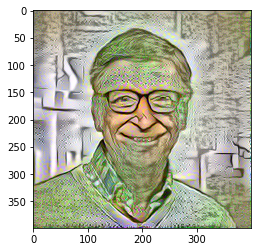

In [71]:
step = 0
epochs = 5
steps_per_epoch = 20
image = tf.Variable(content_image)

for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  print("Train step: {}".format(step))

plt.imshow(image[-1].numpy())

....................................................................................................Train step: 100
....................................................................................................Train step: 200
....................................................................................................Train step: 300
....................................................................................................Train step: 400
....................................................................................................Train step: 500
....................................................................................................Train step: 600
....................................................................................................Train step: 700
....................................................................................................Train step: 800
........................................................................

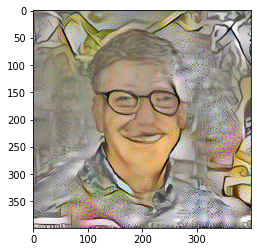

In [73]:
target_image = tf.Variable(tf.random.uniform(content_image.shape))

step = 0
for n in range(20):
  for m in range(100):
    step += 1
    train_step(target_image)
    print(".", end='')
  print("Train step: {}".format(step))

plt.imshow(target_image[-1].numpy())